In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
import glob
import powerlaw
import matplotlib.cm as cm
import matplotlib.colors as colors
import illustris_python as il
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def get_data_from_fof_file(basepath, i, param1, param2):
    path = glob.glob(basepath+f"fof_subhalo_tab_*{i}.hdf5")[0]
    with h5py.File(path, "r") as f:
        # f.visititems(print_structure)
        cds = f[f'{param1}/{param2}'][:]
    
    return cds

In [3]:
def get_halo_mass_function_pdf(subhalo_masses):
    """ Computes the halo mass function for a given snapshot
    Args:
         subhalo_masses (np.array) : array of each subhalomass
    Returns:
         bin_centers (np.array) : center of bins for the halo mass function values
         y_vals (np.array) : PDF value of the halo mass function for each bin
         alpha (float) : best fit alpha for a power law fit of the halo mass function
         d_alpha (float) : sqrt(variance) of alpha
         m_min (float) : lower cutoff mass used in the fit for alpha
    """
    
    fit = powerlaw.Fit(subhalo_masses)

    alpha = fit.power_law.alpha
    d_alpha = fit.power_law.sigma
    m_min = fit.power_law.xmin
    
    x_vals, y_vals = fit.pdf()
    
    bin_centers = np.sqrt(x_vals[:-1] * x_vals[1:])
    
    return bin_centers, y_vals, alpha, d_alpha, m_min

def get_cosmo_parameters(basepath):
    path = basepath+"param.txt-usedvalues"
    Omega0 = None
    OmegaLambda = None
    HubbleParam = None
    
    with open(path, "r") as f:
        for line in f:
            if "Omega0" in line:
                Omega0 = float(line.split()[-1])
            if "OmegaLambda" in line:
                OmegaLambda = float(line.split()[-1])
            if "HubbleParam" in line:
                HubbleParam = float(line.split()[-1])
    
    return Omega0, OmegaLambda, HubbleParam

def powerlaw_function(m, m_min, alpha):
    return (alpha-1)/m_min * (m/m_min)**(-alpha)

def simple_hist_plot(basepath, snapnum, parameter, resolution, mask_zeros=True):
    
    mask_zeros_value = 0.7 # set zero bins to this value, so that the log colorbar works
    
    # get the data
    coordinates = get_data_from_file(basepath, snapnum, parameter)
    
    # calculate the density for each bin
    dm_particle_mass = 0  # will have units of 10^10 M_sun/h
    box_size = 0  # will have units of ckpc/h
    with h5py.File(basepath+"snap_000.hdf5", "r") as f:
        header = f['Header']
        dm_particle_mass = header.attrs['MassTable'][1]
        box_size = header.attrs['BoxSize']
    physical_bin_volume = (box_size/resolution)**2 * box_size  # this is a projection, so one axis has the full length of the box
    unit_density_of_bin = dm_particle_mass/physical_bin_volume*1e10  # M_sun/ckpc
    
    
    # calculate the hist
    h, xedges, yedges = np.histogram2d(coordinates[:, 0], coordinates[:, 1], bins=resolution)
    
    if mask_zeros:
        h[h == 0] = mask_zeros_value
        norm = mpl.colors.LogNorm(vmin=h.min(), vmax=h.max())
    else:
        norm = mpl.colors.LogNorm(vmax=h.max())

    # plot
    fig, ax = plt.subplots(dpi=150)
    img = ax.imshow(h.T, origin='lower', cmap='viridis',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    norm=norm, interpolation='nearest')

    cbar = plt.colorbar(img, ax=ax)
    
    # make colorbar nice
    ticks = cbar.get_ticks()
    new_labels = [f"{tick * unit_density_of_bin:.1e}" for tick in ticks]
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(new_labels)
    cbar.set_label(r"Density [$M_\odot$/ckpc]")
    
    ax.set_xlabel('x [ckpc/h]')
    ax.set_ylabel('y [ckpc/h]')
    ax.set_title('2D Projection Histrogramm')
    plt.show()

In [4]:
def get_data_from_file(basepath, i, param):
    path = glob.glob(basepath+f"snap_*{i}.hdf5")[0]
    with h5py.File(path, "r") as f:
        cds = f[f'PartType0/{param}'][:]
    
    return cds

Calculating best minimal value for power law fit
0.3089 0.6911 0.6774


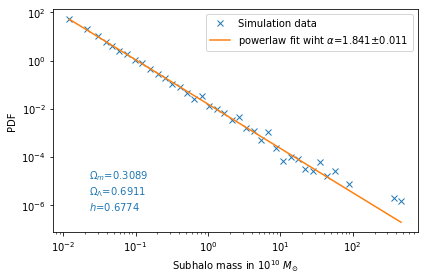

In [5]:
dirpath = f"/u/jerbo/arepo/run/scaling_sims_with_gas/"

path = dirpath+f"/sim_n8_particles/output/"

subhalo_masses = get_data_from_fof_file(path, 10, 'Subhalo', 'SubhaloMass')

bin_centers, y_vals, alpha, d_alpha, m_min = get_halo_mass_function_pdf(subhalo_masses)

Omega0, OmegaLambda, HubbleParam = get_cosmo_parameters(path+"../")
print(Omega0, OmegaLambda, HubbleParam)

f, ax = plt.subplots()

plt.plot(bin_centers, y_vals, 'x', label="Simulation data")
plt.plot(bin_centers, powerlaw_function(bin_centers, m_min, alpha),
         label=r"powerlaw fit wiht $\alpha$="+f"{alpha:.3f}"+r"$\pm$"+f"{d_alpha:.3f}")

plt.text(0.1, 0.1, r"$\Omega_m$="+f"{Omega0}\n"+r"$\Omega_\Lambda$="+f"{OmegaLambda}\n"+r"$h$="+f"{HubbleParam}",
         fontsize=10, c="tab:blue", alpha=1, transform=ax.transAxes)

plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"PDF")
plt.xlabel(r"Subhalo mass in $10^{10}$ $M_{\odot}$")
plt.legend()
plt.tight_layout()
plt.show()

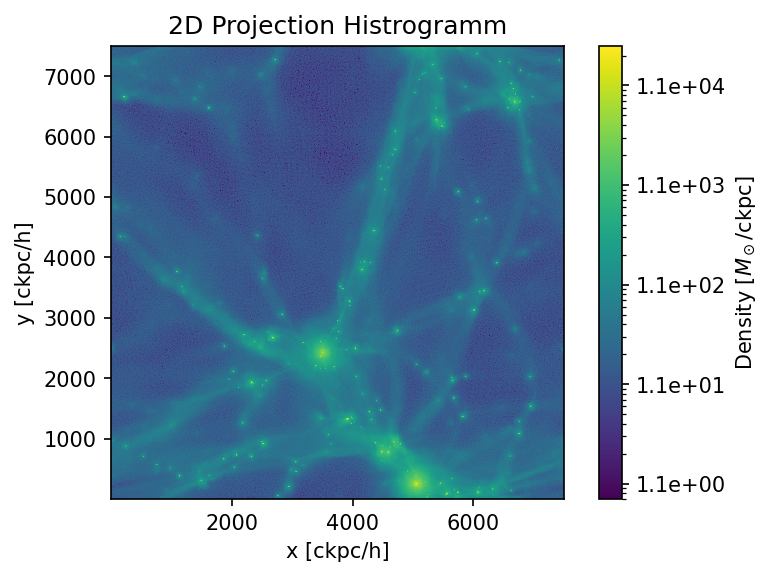

In [6]:
simple_hist_plot(path, 10, 'Coordinates', 512)

## Entire Box

In [7]:
def get_data_from_file(basepath, i, particle_type, param2):
    if particle_type == "dm":
        param1 = "PartType1"
    elif particle_type == "b":
        param1 = "PartType0"
    elif particle_type == "stars":
        param1 = "PartType4"
    else:
        print("Error: unknown particle type!")
        return None
    path = glob.glob(basepath+f"snap_*{i}.hdf5")[0]
    with h5py.File(path, "r") as f:
        cds = f[f'{param1}/{param2}'][:]
    
    return cds

In [8]:
path = "/u/jerbo/arepo/run/scaling_sims_with_gas/sim_n8_particles/output/"
resolution = 512
snapnum = 10

In [9]:
# get the data
coordinates_dm = get_data_from_file(path, snapnum, "dm", "Coordinates")
coordinates_b = get_data_from_file(path, snapnum, "b", "Coordinates")
masses_b = get_data_from_file(path, snapnum, "b", "Masses")
coordinates_stars = get_data_from_file(path, snapnum, "stars", "Coordinates")
masses_stars = get_data_from_file(path, snapnum, "stars", "Masses")

# calculate the density for each bin
dm_particle_mass = 0  # will have units of 10^10 M_sun/h
box_size = 0  # will have units of ckpc/h
with h5py.File(path+"snap_000.hdf5", "r") as f:
    header = f['Header']
    dm_particle_mass = header.attrs['MassTable'][1]
    box_size = header.attrs['BoxSize']
physical_bin_volume = (box_size/resolution)**2 * box_size  # this is a projection, so one axis has the full length of the box
unit_density_of_bin = dm_particle_mass/physical_bin_volume*1e10  # M_sun/ckpc

In [10]:
h_b, xedges_b, yedges_b = np.histogram2d(coordinates_b[:, 0], coordinates_b[:, 1],
                                         weights=masses_b, bins=resolution, density=True)
h_b = h_b/physical_bin_volume

h_dm, xedges_dm, yedges_dm = np.histogram2d(coordinates_dm[:, 0], coordinates_dm[:, 1],
                                            bins=resolution, density=True,
                                            range=[[xedges_b[0], xedges_b[-1]], [yedges_b[0], yedges_b[-1]]])
h_dm = h_dm*unit_density_of_bin

h_stars, xedges_stars, yedges_stars = np.histogram2d(coordinates_stars[:, 0], coordinates_stars[:, 1],
                                                     weights=masses_stars, bins=resolution, density=True,
                                            range=[[xedges_b[0], xedges_b[-1]], [yedges_b[0], yedges_b[-1]]])
h_stars = h_stars/physical_bin_volume

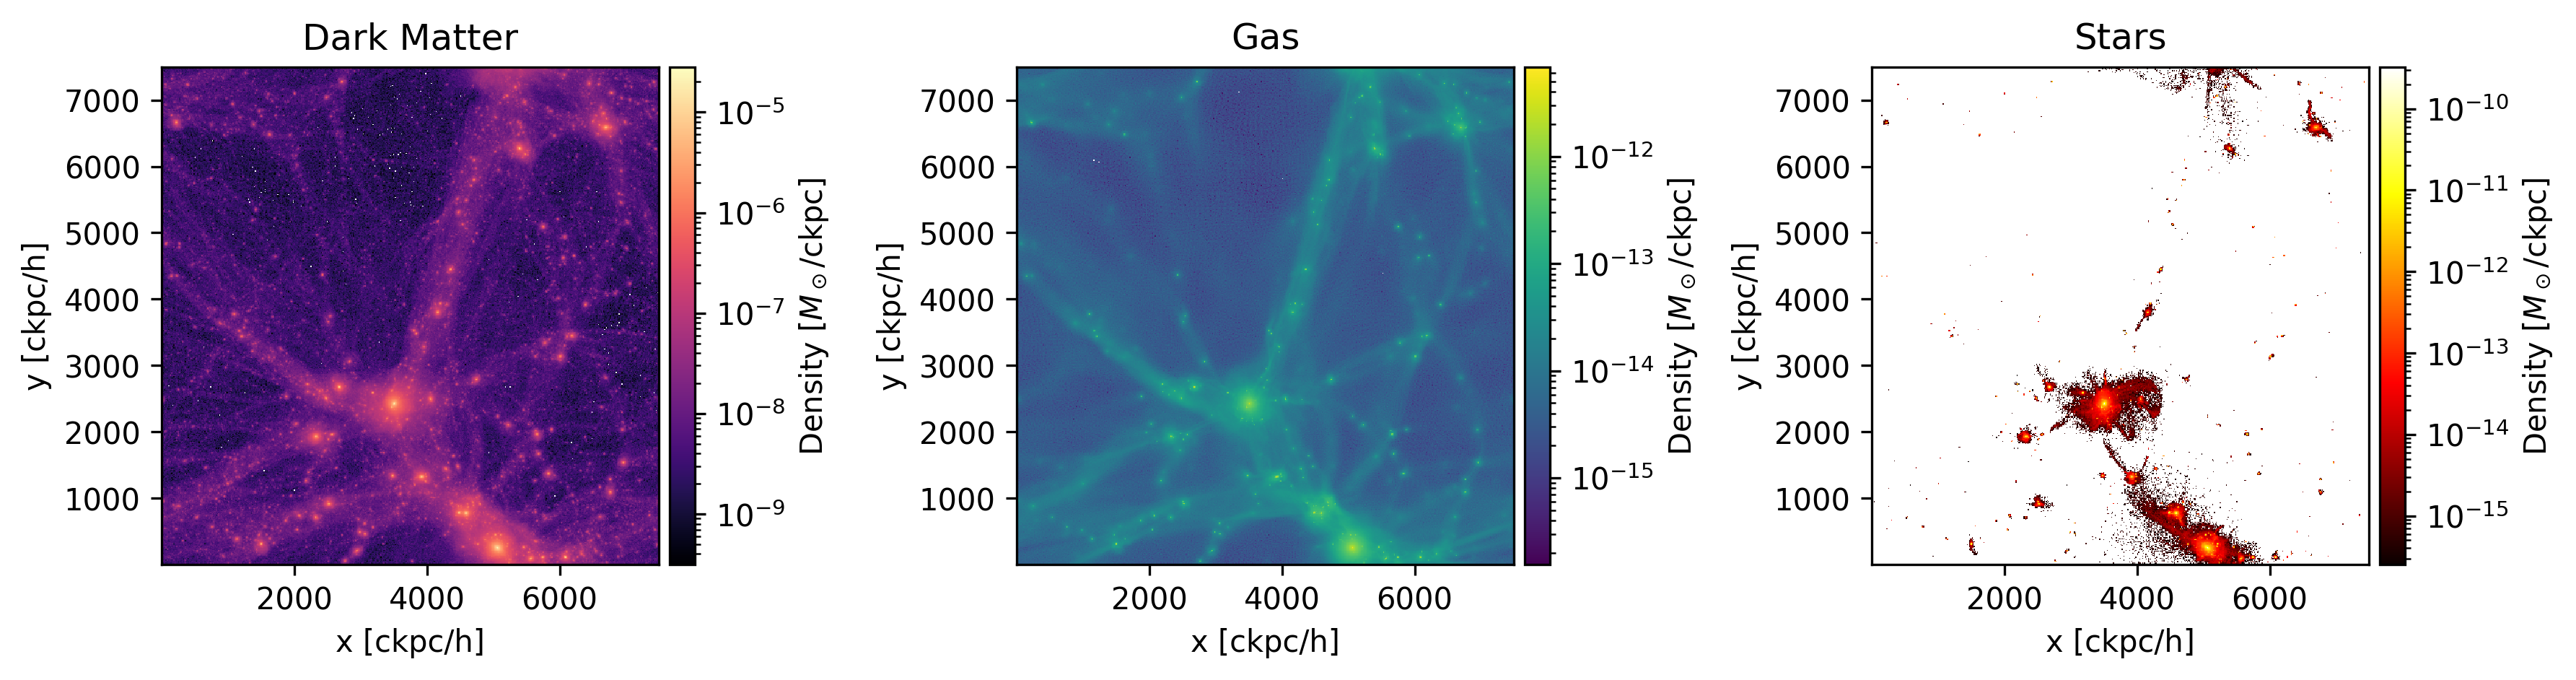

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12,4), dpi=300)

#################### Dark Matter Plot ####################

norm_dm = mpl.colors.LogNorm(vmax=h_dm.max())

img_dm = ax[0].imshow(h_dm.T, origin='lower', cmap='magma',
                extent=[xedges_dm[0], xedges_dm[-1], yedges_dm[0], yedges_dm[-1]],
                norm=norm_dm, interpolation='nearest')

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(img_dm, cax=cax)
cbar.set_label(r"Density [$M_\odot$/ckpc]")

ax[0].set_xlabel('x [ckpc/h]')
ax[0].set_ylabel('y [ckpc/h]')
ax[0].set_title('Dark Matter')

#################### Baryon Plot ####################
norm_b = mpl.colors.LogNorm(vmax=h_b.max())

img_b = ax[1].imshow(h_b.T, origin='lower', cmap='viridis',
                extent=[xedges_b[0], xedges_b[-1], yedges_b[0], yedges_b[-1]],
                norm=norm_b, interpolation='nearest')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(img_b, cax=cax)
cbar.set_label(r"Density [$M_\odot$/ckpc]")

ax[1].set_xlabel('x [ckpc/h]')
ax[1].set_ylabel('y [ckpc/h]')
ax[1].set_title('Gas')

#################### Stars Plot ####################

norm_stars = mpl.colors.LogNorm(vmax=h_stars.max())

img_stars = ax[2].imshow(h_stars.T, origin='lower', cmap='hot',
                extent=[xedges_stars[0], xedges_stars[-1], yedges_stars[0], yedges_stars[-1]],
                norm=norm_stars, interpolation='nearest')

divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(img_stars, cax=cax)
cbar.set_label(r"Density [$M_\odot$/ckpc]")

ax[2].set_xlabel('x [ckpc/h]')
ax[2].set_ylabel('y [ckpc/h]')
ax[2].set_title('Stars')

plt.tight_layout()
plt.savefig("test_plot_dm_gas_stars.pdf", format="PDF")
plt.show()

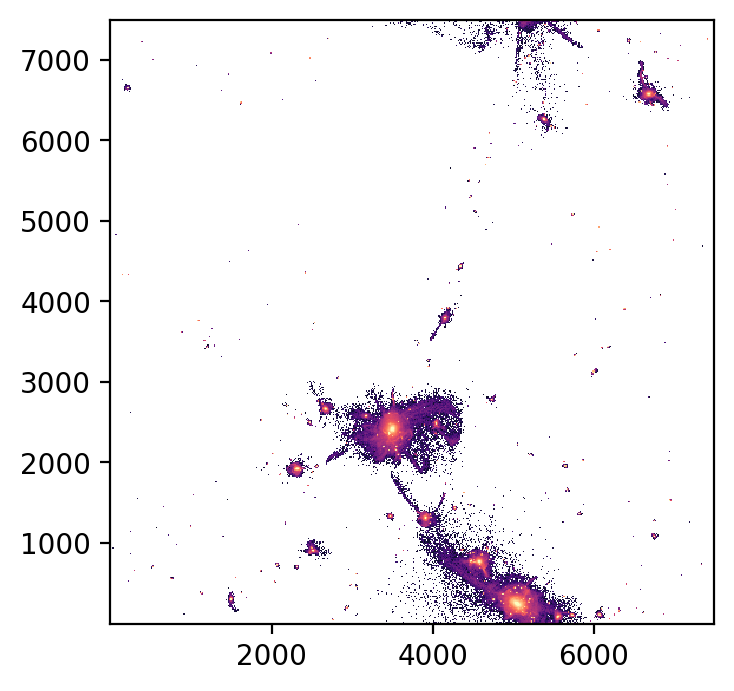

In [12]:
fig, ax = plt.subplots(dpi=200)

norm_b = mpl.colors.LogNorm(vmax=h_b.max())
norm_dm = mpl.colors.LogNorm(vmax=h_dm.max())

img_dm = ax.imshow(h_dm.T, origin='lower', cmap='viridis',
                extent=[xedges_dm[0], xedges_dm[-1], yedges_dm[0], yedges_dm[-1]],
                norm=norm_dm, interpolation='nearest', alpha=0)

img_b = ax.imshow(h_b.T, origin='lower', cmap='magma',
                extent=[xedges_b[0], xedges_b[-1], yedges_b[0], yedges_b[-1]],
                norm=norm_b, interpolation='nearest', alpha=0)

img_stars = ax.imshow(h_stars.T, origin='lower', cmap='magma',
                extent=[xedges_b[0], xedges_b[-1], yedges_b[0], yedges_b[-1]],
                norm=norm_b, interpolation='nearest', alpha=1)

plt.show()

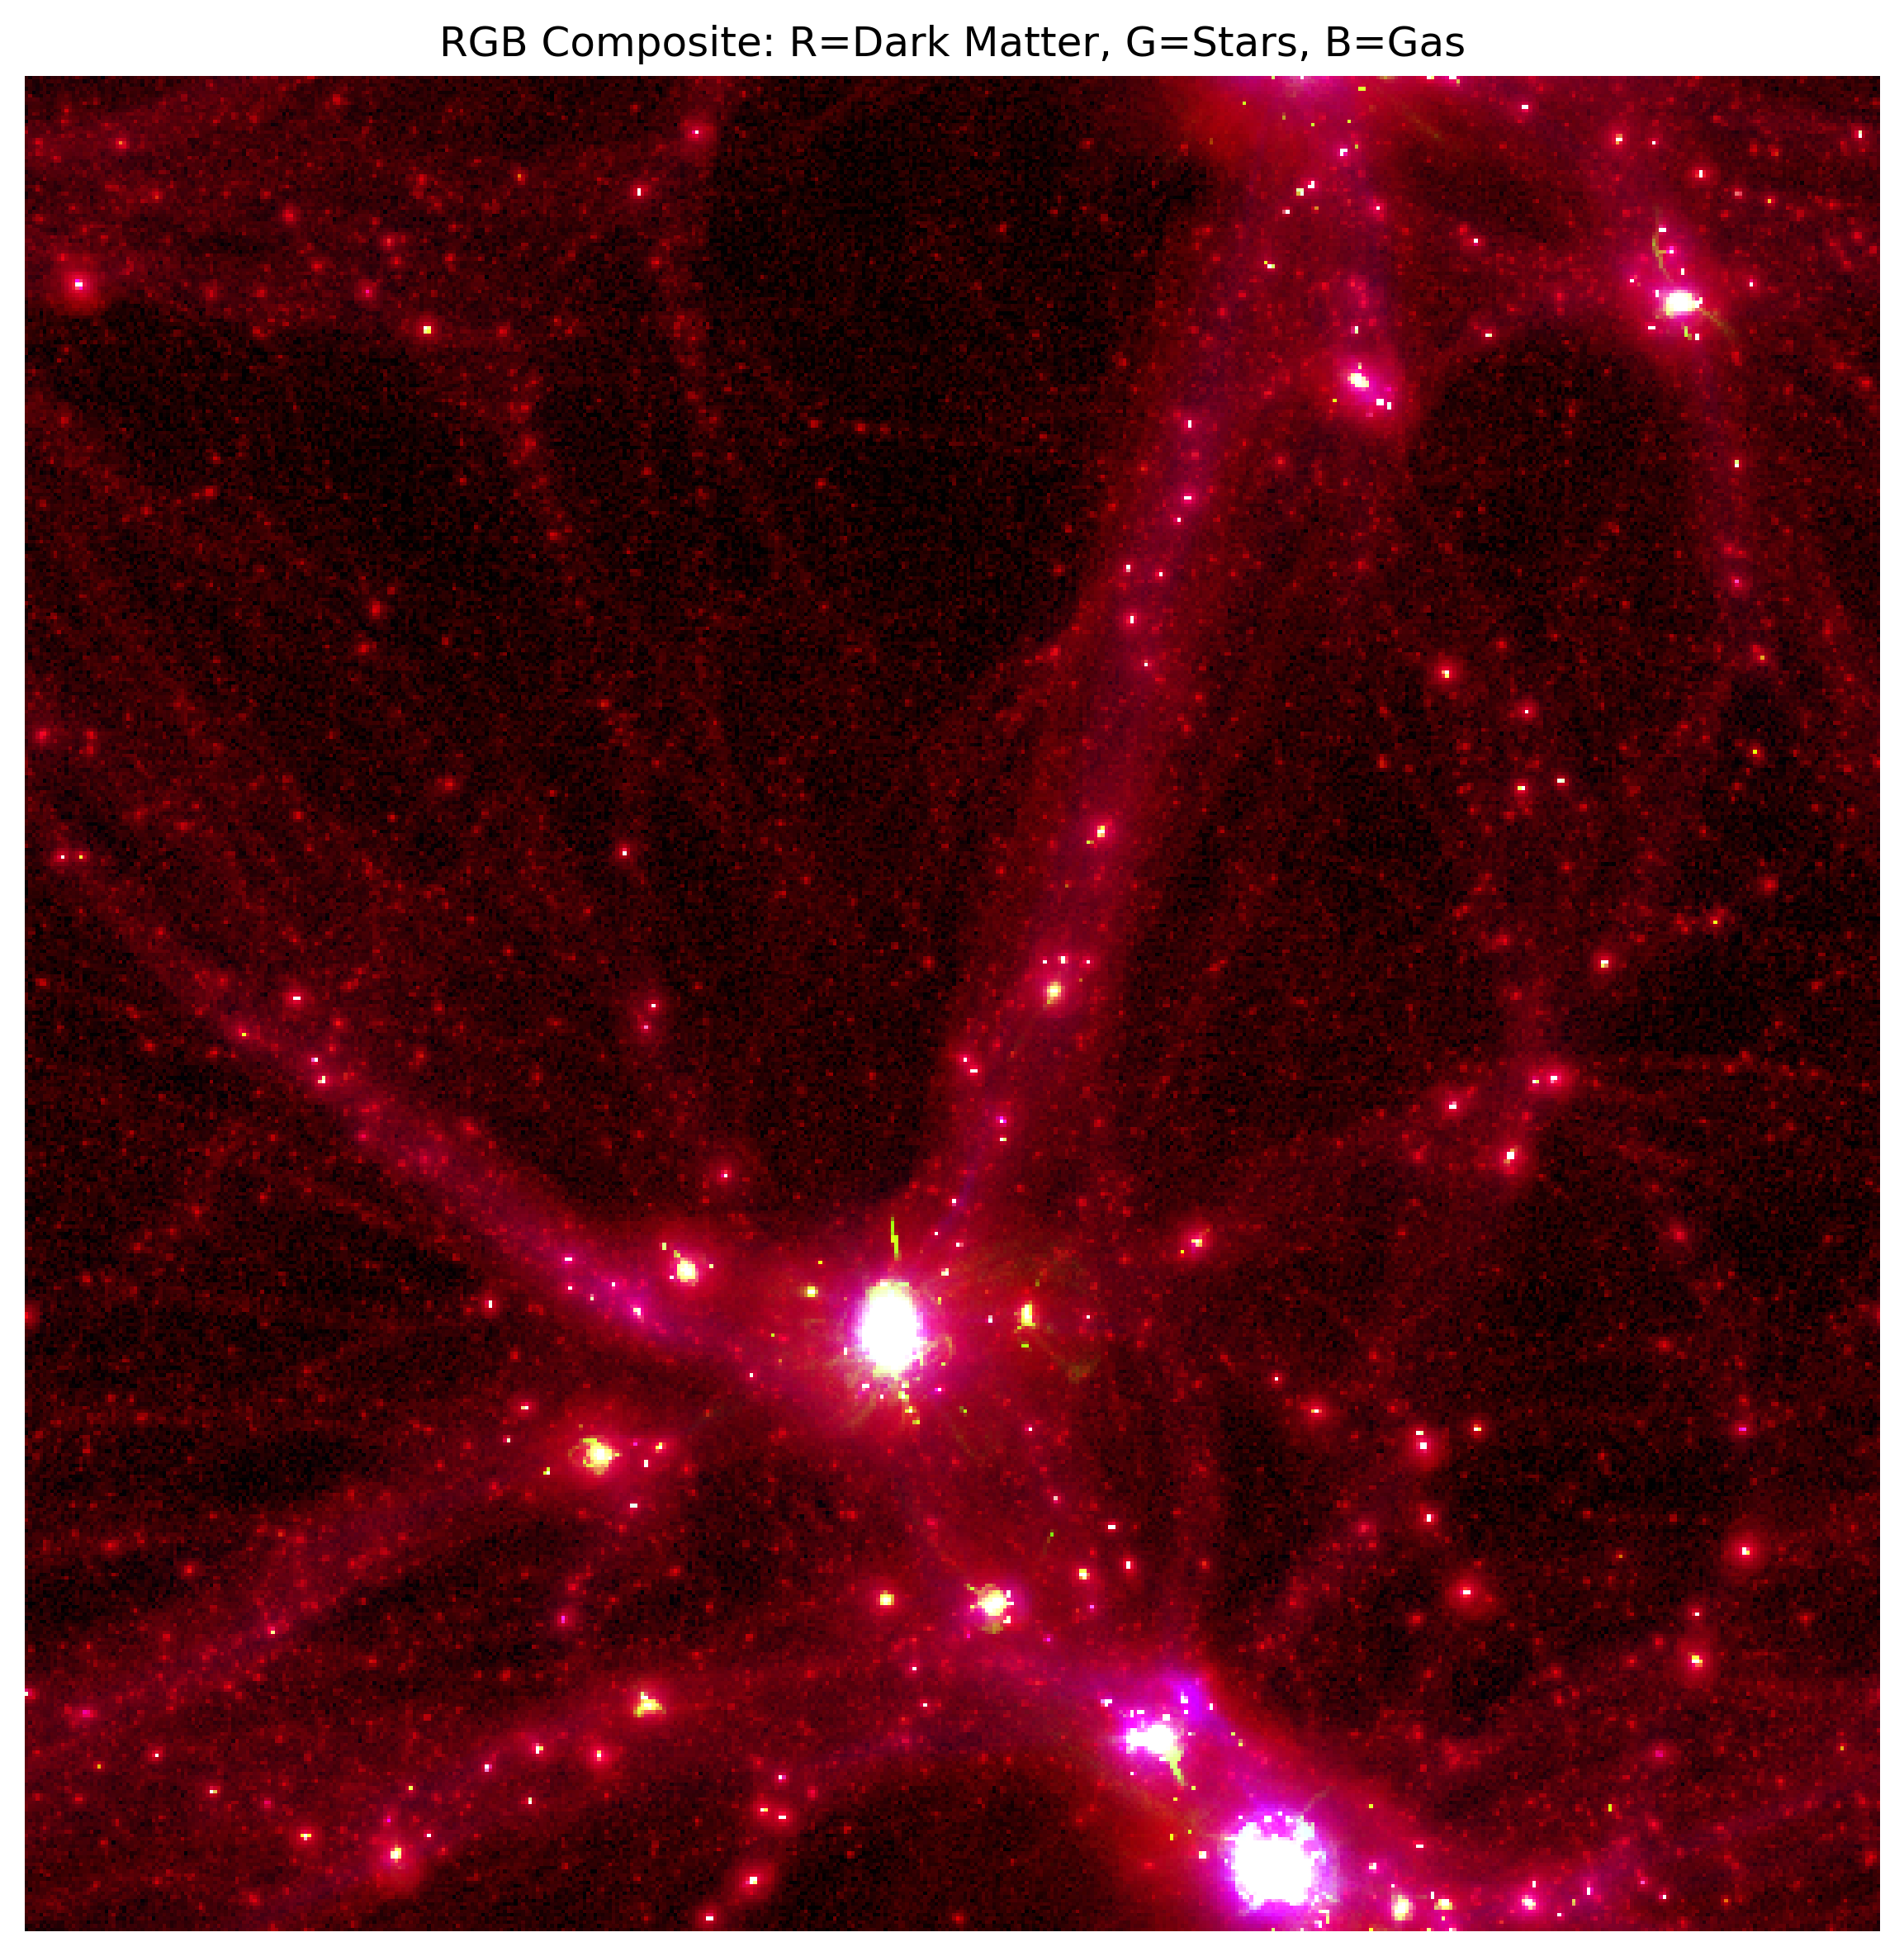

In [13]:
# Normalize log-wise for better contrast
def normalize(data, lo=2, hi=99.5):
    data = np.log10(data + 1e-12)
    vmin, vmax = np.percentile(data, [lo, hi])
    return np.clip((data - vmin) / (vmax - vmin), 0, 1)

g = normalize(h_stars.T, lo=2, hi=99.5)  # Stars → green
b = normalize(h_b.T, lo=2, hi=99.5)     # Gas → blue
r = normalize(h_dm.T, lo=2, hi=99.5)    # DM → red

rgb = np.stack([r, g, b], axis=-1)

# Plot the RGB composite
plt.figure(figsize=(8, 8), dpi=300)
plt.imshow(rgb, origin="lower")
plt.title("RGB Composite: R=Dark Matter, G=Stars, B=Gas")
plt.axis("off")
plt.tight_layout()
plt.savefig("test_plot_rgb.pdf", format="PDF")
plt.show()

### !This is not working the way i want! -> probably should look into sph stuff as discussed

## Zoom in on one Galaxy

In [14]:
def get_data_from_file(basepath, i, particle_type, param2):
    if particle_type == "dm":
        param1 = "PartType1"
    elif particle_type == "b":
        param1 = "PartType0"
    elif particle_type == "stars":
        param1 = "PartType4"
    else:
        print("Error: unknown particle type!")
        return None
    path = glob.glob(basepath+f"snap_*{i}.hdf5")[0]
    with h5py.File(path, "r") as f:
        cds = f[f'{param1}/{param2}'][:]
    
    return cds

In [15]:
path = "/u/jerbo/arepo/run/scaling_sims_with_gas/sim_n8_particles/output/"
resolution = 512
snapnum = 10

In [16]:
subhalo_pos = get_data_from_fof_file(path, snapnum, "Subhalo", "SubhaloPos")
subhalo_mass = get_data_from_fof_file(path, snapnum, "Subhalo", "SubhaloMass")
subhalo_halfmassrad = get_data_from_fof_file(path, snapnum, "Subhalo", "SubhaloHalfmassRad")

subhalo_mass = np.sort(subhalo_mass)

In [17]:
index_biggest_subhalo = np.where(subhalo_mass==subhalo_mass[0])[0][0]
subhalo_coords = subhalo_pos[index_biggest_subhalo]
subhalo_rad = subhalo_halfmassrad[index_biggest_subhalo]*1

In [18]:
print(subhalo_mass[3], subhalo_coords, subhalo_rad)

0.0010568853 [5057.3193   251.25342 5778.211  ] 97.78441619873047


In [19]:
coordinates_dm = get_data_from_file(path, snapnum, "dm", "Coordinates")

coordinates_b = get_data_from_file(path, snapnum, "b", "Coordinates")
masses_b = get_data_from_file(path, snapnum, "b", "Masses")

coordinates_stars = get_data_from_file(path, snapnum, "stars", "Coordinates")
masses_stars = get_data_from_file(path, snapnum, "stars", "Masses")

In [20]:
distances_dm = np.linalg.norm(coordinates_dm - subhalo_coords, axis=1)
coordinates_dm = coordinates_dm[distances_dm < subhalo_rad]

distances_b = np.linalg.norm(coordinates_b - subhalo_coords, axis=1)
masses_b = masses_b[distances_b < subhalo_rad]
coordinates_b = coordinates_b[distances_b < subhalo_rad]

distances_stars = np.linalg.norm(coordinates_stars - subhalo_coords, axis=1)
masses_stars = masses_stars[distances_stars < subhalo_rad]
coordinates_stars = coordinates_stars[distances_stars < subhalo_rad]

In [21]:
h_b, xedges_b, yedges_b = np.histogram2d(coordinates_b[:, 0], coordinates_b[:, 1],
                                         weights=masses_b, bins=resolution, density=True)
# h_b = h_b/physical_bin_volume

h_dm, xedges_dm, yedges_dm = np.histogram2d(coordinates_dm[:, 0], coordinates_dm[:, 1],
                                            bins=resolution, density=True,
                                            range=[[xedges_b[0], xedges_b[-1]], [yedges_b[0], yedges_b[-1]]])
# h_dm = h_dm*unit_density_of_bin

h_stars, xedges_stars, yedges_stars = np.histogram2d(coordinates_stars[:, 0], coordinates_stars[:, 1],
                                                     weights=masses_stars, bins=resolution, density=True,
                                            range=[[xedges_b[0], xedges_b[-1]], [yedges_b[0], yedges_b[-1]]])
# h_stars = h_stars/physical_bin_volume

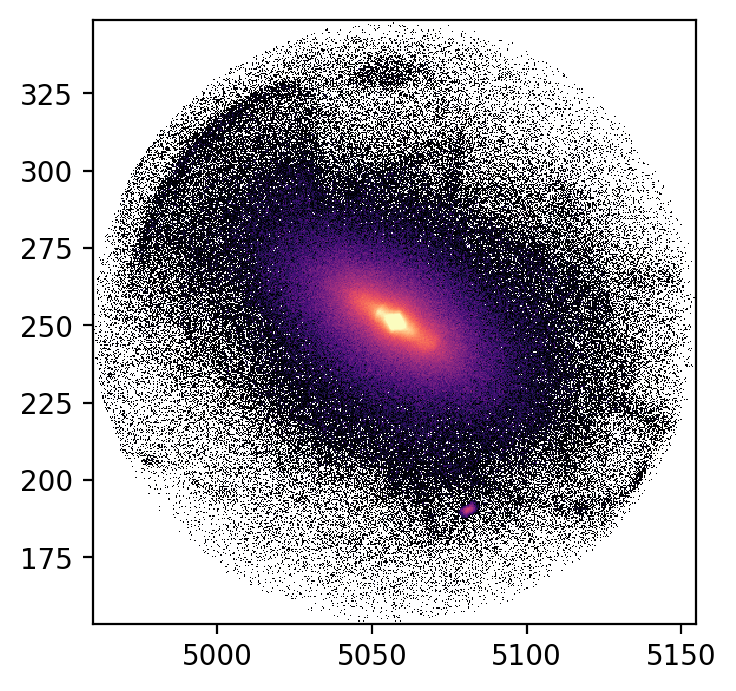

In [22]:
fig, ax = plt.subplots(dpi=200)

norm_b = mpl.colors.LogNorm(vmax=h_b.max())
norm_dm = mpl.colors.LogNorm(vmax=h_dm.max())

img_dm = ax.imshow(h_dm.T, origin='lower', cmap='viridis',
                extent=[xedges_dm[0], xedges_dm[-1], yedges_dm[0], yedges_dm[-1]],
                norm=norm_dm, interpolation='nearest', alpha=0)

img_b = ax.imshow(h_b.T, origin='lower', cmap='magma',
                extent=[xedges_b[0], xedges_b[-1], yedges_b[0], yedges_b[-1]],
                norm=norm_b, interpolation='nearest', alpha=0)

img_stars = ax.imshow(h_stars.T, origin='lower', cmap='magma',
                extent=[xedges_b[0], xedges_b[-1], yedges_b[0], yedges_b[-1]],
                norm=norm_b, interpolation='nearest', alpha=1)

plt.show()

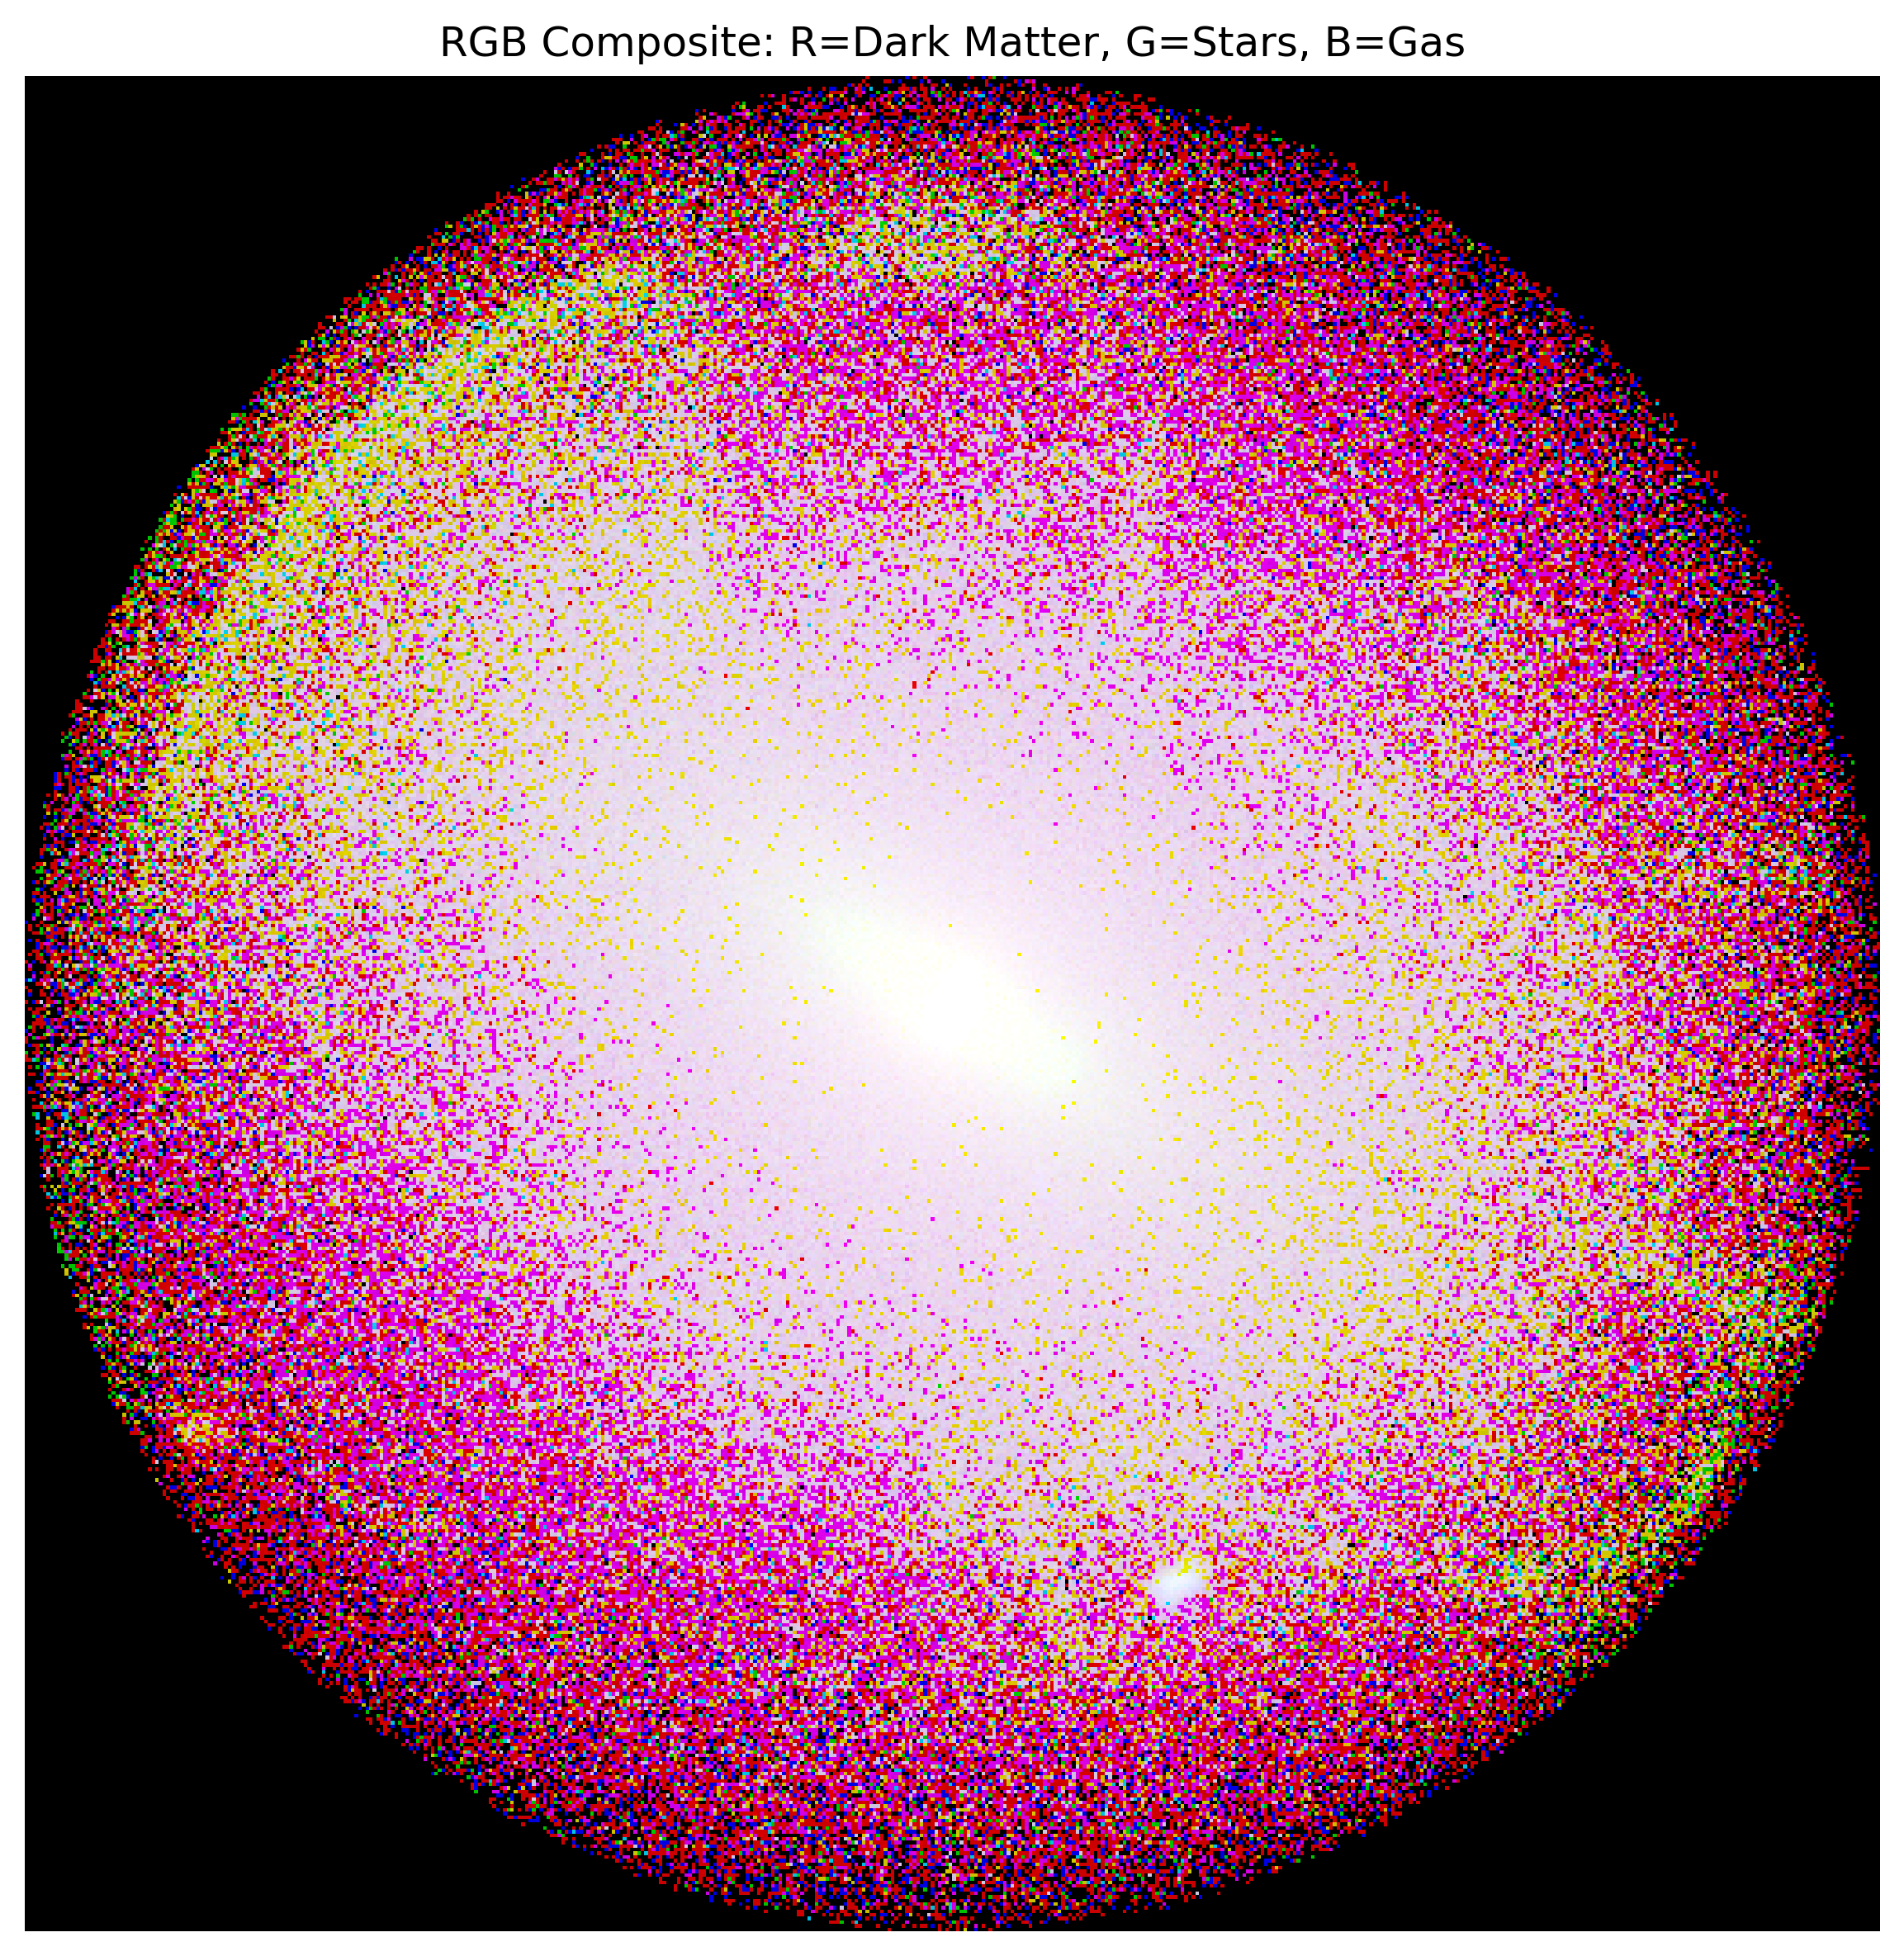

In [23]:
# Normalize log-wise for better contrast
def normalize(data, lo=2, hi=99.5):
    data = np.log10(data + 1e-12)
    vmin, vmax = np.percentile(data, [lo, hi])
    return np.clip((data - vmin) / (vmax - vmin), 0, 1)

g = normalize(h_stars.T, lo=2, hi=99.5)  # Stars → green
b = normalize(h_b.T, lo=2, hi=99.5)     # Gas → blue
r = normalize(h_dm.T, lo=2, hi=99.5)    # DM → red

rgb = np.stack([r, g, b], axis=-1)

# Plot the RGB composite
plt.figure(figsize=(8, 8), dpi=300)
plt.imshow(rgb, origin="lower")
plt.title("RGB Composite: R=Dark Matter, G=Stars, B=Gas")
plt.axis("off")
plt.tight_layout()
# plt.savefig("test_plot_rgb.pdf", format="PDF")
plt.show()

In [25]:
import glob
basepath = "/u/jerbo/arepo/run/grid_search_with_gas/"
paths = [glob.glob(basepath+f"grid_point_{i}/job.err.*") for i in range(1, 21)]


In [26]:
print(glob.glob(basepath+f"grid_point_1/job.err.*")[0])

/u/jerbo/arepo/run/grid_search_with_gas/grid_point_1/job.err.876955


In [27]:

for i in range(len(paths)):
    try: 
        paths[i] = paths[i][0]
    except:
        pass

count = 0
failed_paths = []
for path in paths:
    if path:
        with open(path, "r") as file:
            a = file.readline()
            if a:
                count += 1
                failed_paths.append(path)
print(count)
print(paths)

failed_paths.append('/u/jerbo/arepo/run/grid_search_with_gas/grid_point_3/job.err.876955')
             
for i in failed_paths:
    print(i)

9
['/u/jerbo/arepo/run/grid_search_with_gas/grid_point_1/job.err.876955', '/u/jerbo/arepo/run/grid_search_with_gas/grid_point_2/job.err.876956', [], '/u/jerbo/arepo/run/grid_search_with_gas/grid_point_4/job.err.876957', '/u/jerbo/arepo/run/grid_search_with_gas/grid_point_5/job.err.876958', '/u/jerbo/arepo/run/grid_search_with_gas/grid_point_6/job.err.876959', '/u/jerbo/arepo/run/grid_search_with_gas/grid_point_7/job.err.876960', '/u/jerbo/arepo/run/grid_search_with_gas/grid_point_8/job.err.876961', '/u/jerbo/arepo/run/grid_search_with_gas/grid_point_9/job.err.876962', '/u/jerbo/arepo/run/grid_search_with_gas/grid_point_10/job.err.876963', '/u/jerbo/arepo/run/grid_search_with_gas/grid_point_11/job.err.876964', '/u/jerbo/arepo/run/grid_search_with_gas/grid_point_12/job.err.876965', '/u/jerbo/arepo/run/grid_search_with_gas/grid_point_13/job.err.876966', '/u/jerbo/arepo/run/grid_search_with_gas/grid_point_14/job.err.876967', '/u/jerbo/arepo/run/grid_search_with_gas/grid_point_15/job.err.87